In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

Reading in mutation/generation time estimates from Kuderna. I will assume that chromosome X has 80 % of the mutation rate of autosomes, corresponding to a 4:1 male bias in mutations.

In [2]:
# Mutation rate percentage calc.
(3*1/3+1*2/3)/(3*1/2+1*1/2)

# Even if females have no mutations, it's only 2/3
# (4*1/3+0*2/3)/(4*1/2+0*1/2)

0.8333333333333333

In [3]:
0.75*0.8333333333333333

0.625

In [4]:
kuderna_data = pd.read_csv("../data/science.abn7829_data_s2.csv")

In [5]:
# I pick out the following columns
col_species_mut = ['SPECIES_BINOMIAL', 'GENUS', 'SPECIES', 'FAMILY', 'GENERATION_LENGTH', 'MU_PER_GENERATION',
       'MU_PER_YEAR', 'EFFECTIVE_POP_SIZE']
df_species_mut = kuderna_data[col_species_mut]

<Axes: xlabel='MU_PER_YEAR', ylabel='Count'>

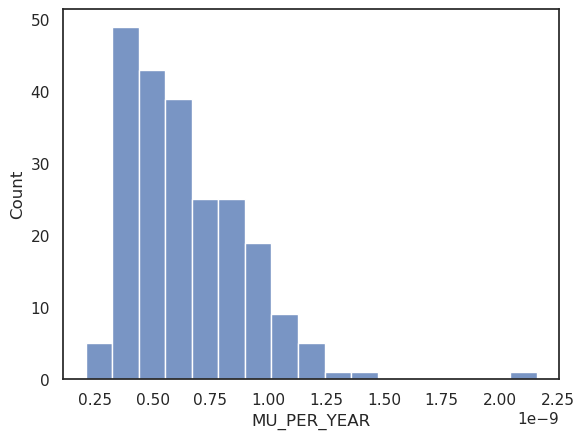

In [6]:
sns.histplot(kuderna_data[col_species_mut].MU_PER_YEAR)

<Axes: xlabel='GENERATION_LENGTH', ylabel='Count'>

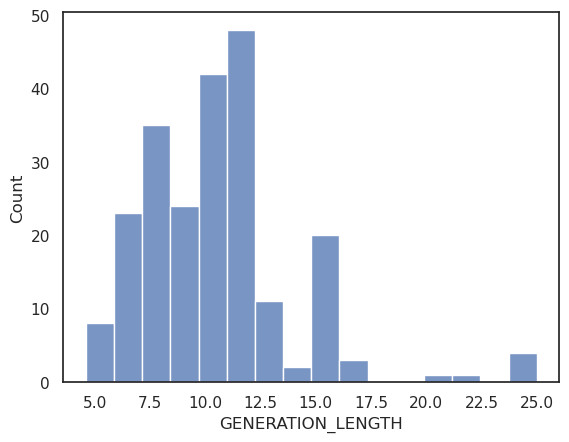

In [7]:
sns.histplot(kuderna_data[col_species_mut].GENERATION_LENGTH)

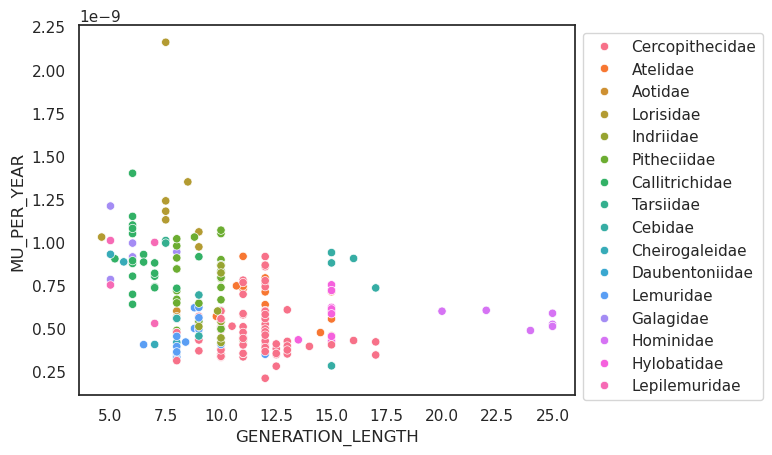

In [8]:
g = sns.scatterplot(data=kuderna_data, x="GENERATION_LENGTH", y="MU_PER_YEAR", hue="FAMILY")
plt.legend(bbox_to_anchor=(1.0, 1))

In [9]:
metadata_dir = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"


metadata_dirs = glob.glob(metadata_dir+"*_individuals.txt")

df_l = []
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    df_l.append(dir_metadata)
all_inds = pd.concat(df_l)

In [10]:
all_inds.loc[all_inds.GVCF_ID == "PD_0629"]

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,SUBSPECIES,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y
0,SAMEA112483158,PD_0629,PD_0629,ERS14600509,PRJEB59576,Carlito_syrichta_ssp,Carlito_syrichta_ssp,Cephalopachus_bancanus_ssp,Carlito,syrichta,ssp,Unknown,Unknown,26.723,0.979,Unknown,Unknown,Unknown,Unknown


In [11]:
df_species_mut.loc[df_species_mut.GENUS == "Carlito"]

,SPECIES_BINOMIAL,GENUS,SPECIES,FAMILY,GENERATION_LENGTH,MU_PER_GENERATION,MU_PER_YEAR,EFFECTIVE_POP_SIZE
32,Carlito_syrichta,Carlito,syrichta,Tarsiidae,7.5,7.580000e-09,1.010000e-09,74616


In [12]:
c_list = []
for p in glob.glob("../steps/cobraa/*"):
    if len(glob.glob(p+"/*final_parameters.txt")) >= 1:
        c_list.append(glob.glob(p+"/*final_parameters.txt")[0])
c_list

['../steps/cobraa/PD_0346/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0156/HiC_scaffold_1_final_parameters.txt',
 '../steps/cobraa/PD_0121/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0119/CM063169.1_final_parameters.txt',
 '../steps/cobraa/SAMN23530509/aut_final_parameters.txt',
 '../steps/cobraa/PD_0009/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0351/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0122/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts10_te34_final_parameters.txt',
 '../steps/cobraa/PD_0174/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0120/CM063169.1_final_parameters.txt',
 '../steps/cobraa/PD_0522/CM104434.1_final_parameters.txt',
 '../steps/cobraa/SAMN23530506/HiC_scaffold_1_final_parameters.txt',
 '../steps/cobraa/SAMN43386187/CM104434.1_final_parameters.txt']

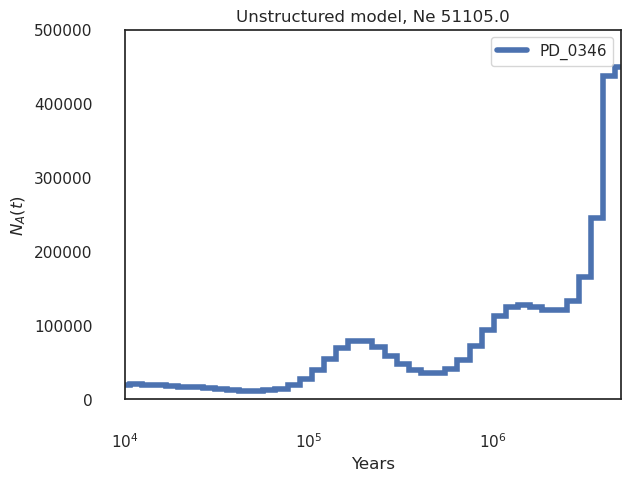

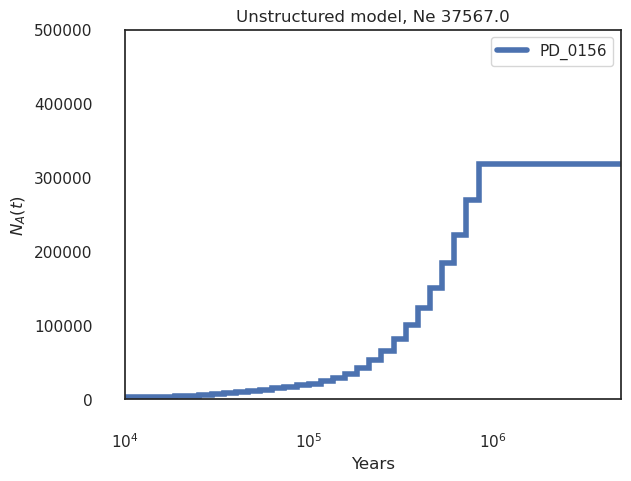

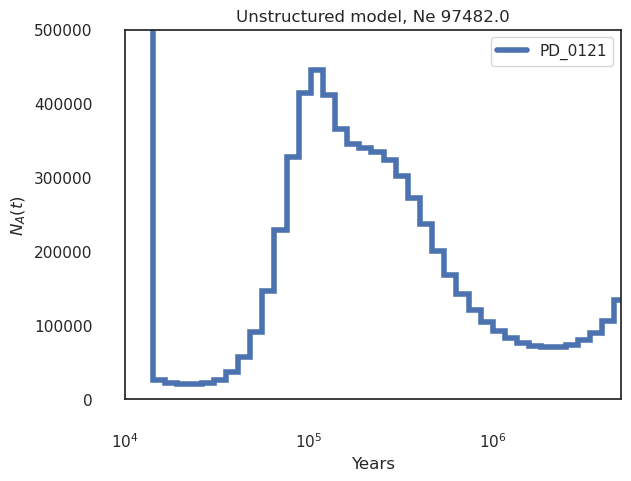

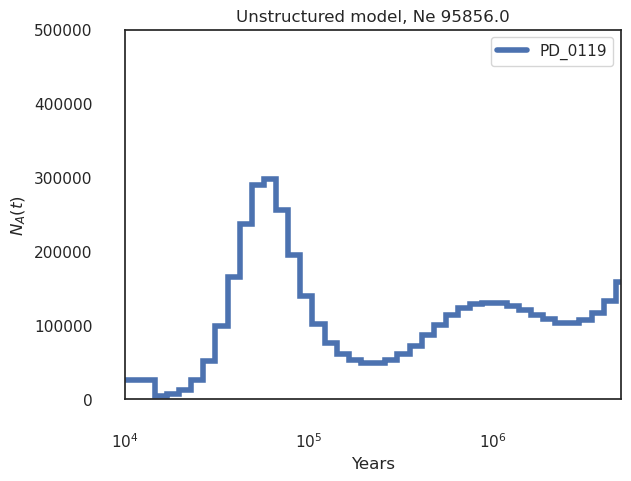

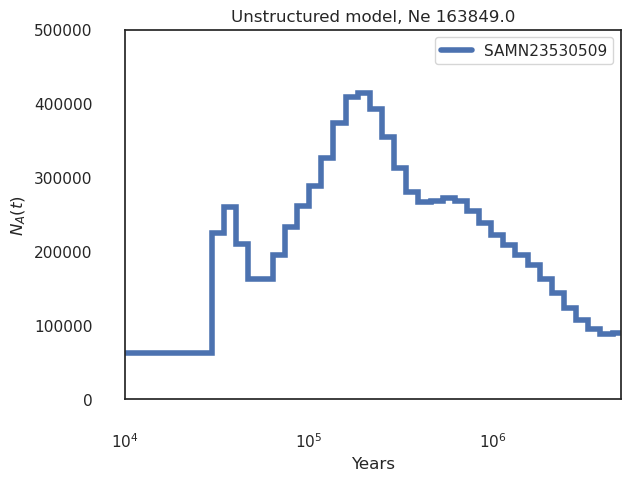

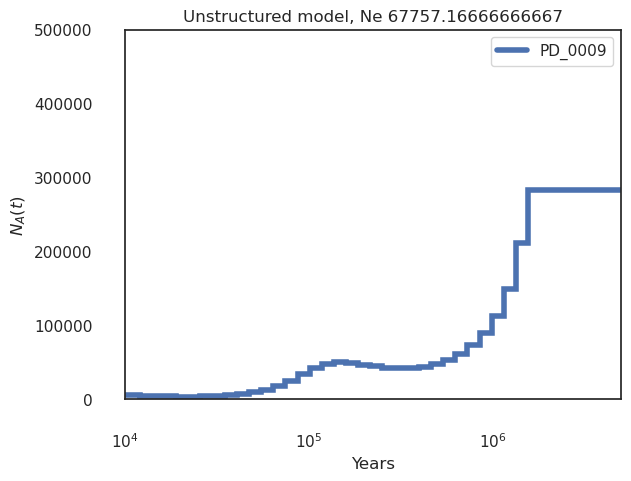

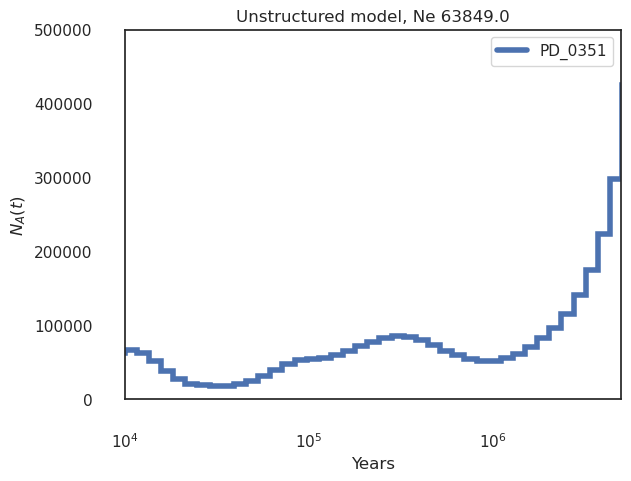

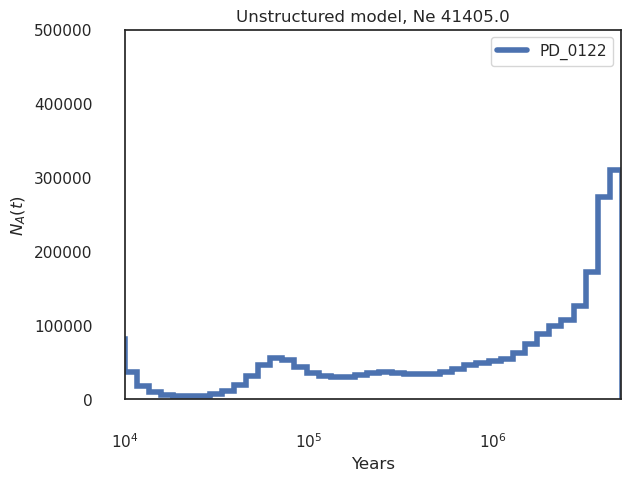

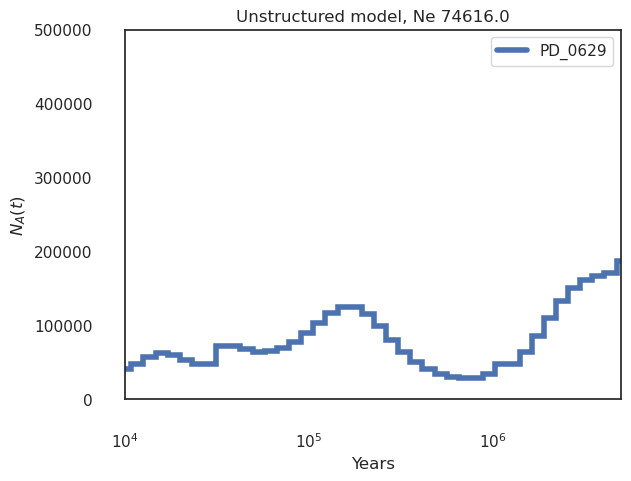

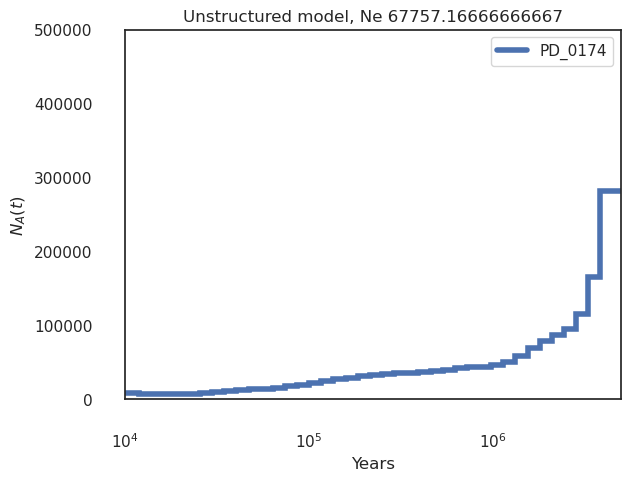

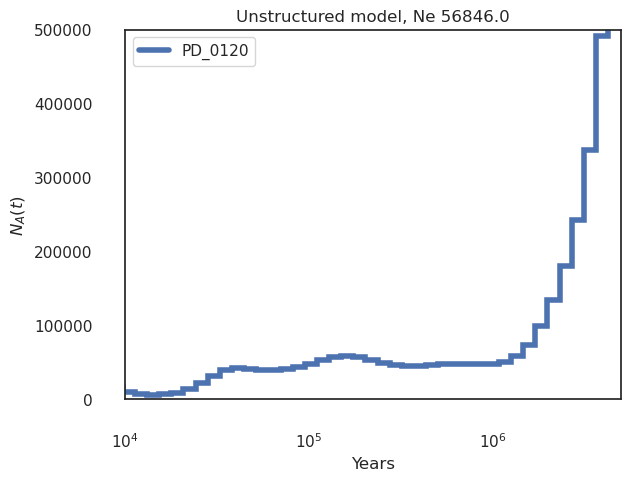

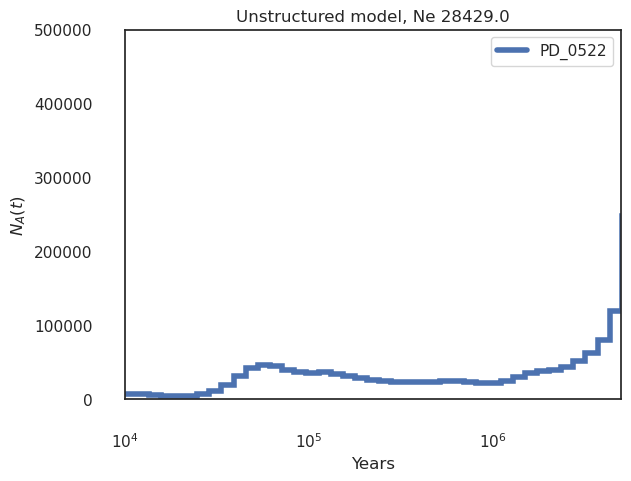

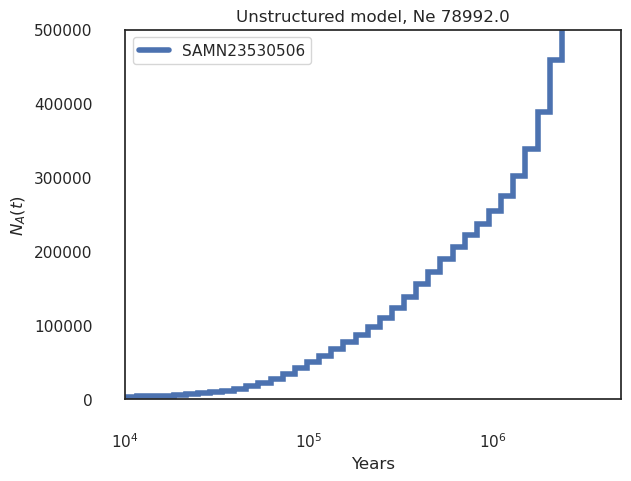

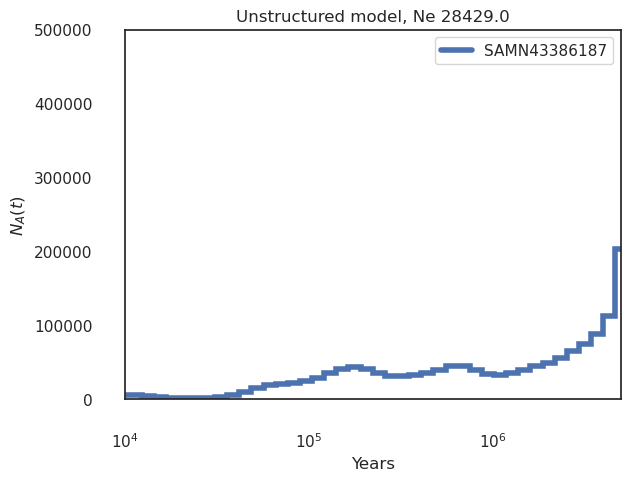

In [13]:
for p in c_list:
    label_tag = p.split("/")[-2]
    ind_inf = all_inds.loc[all_inds.GVCF_ID == label_tag]
    gs = ind_inf.GENUS.iloc[0]+"_"+ind_inf.SPECIES.iloc[0]
    gs_df = df_species_mut.loc[df_species_mut.SPECIES_BINOMIAL == gs]
    g_df = df_species_mut.loc[df_species_mut.GENUS == ind_inf.GENUS.iloc[0]] 
    if len(gs_df) > 0:
        mu = gs_df.MU_PER_GENERATION.mean()
        gen = gs_df.GENERATION_LENGTH.mean()
        kuderna_Ne = gs_df.EFFECTIVE_POP_SIZE.mean()
    elif len(g_df) > 0:
        mu = g_df.MU_PER_GENERATION.mean()
        gen = g_df.GENERATION_LENGTH.mean()
        kuderna_Ne = g_df.EFFECTIVE_POP_SIZE.mean()
    else:
        print(gs)
        continue
    final_params_file = p
    final_params = np.loadtxt(final_params_file)
    time_array = list(final_params[:,1])
    time_array.insert(0,0)
    time_array = np.array(time_array)
    plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=label_tag,linewidth=4,linestyle="solid",baseline=None)
    plt.xlim(1e+04,5e+06)
    plt.ylim(0,50e+04)
    plt.xscale('log')
    plt.ylabel('$N_A(t)$')
    plt.xlabel('Years')
    plt.tick_params(which='major',length=20)
    plt.tick_params(which='minor',length=10)
    plt.legend(ncol=2)
    plt.title('Unstructured model, Ne {}'.format(kuderna_Ne))
    plt.show()

In [14]:
final_params_file

'../steps/cobraa/SAMN43386187/CM104434.1_final_parameters.txt'

In [15]:
ind_inf

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,SUBSPECIES,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y
12,SAMN43386187,SAMN43386187,SAMN43386187,SRS22485649,PRJNA1153068,Hoolock_leuconedys_ssp,Hoolock_leuconedys_ssp,Hoolock_leuconedys_ssp,Hoolock,leuconedys,ssp,F,F,76.517,1.0,70.266,1.0,Unknown,Unknown


Structured check

In [22]:
# Files used
glob.glob("../steps/cobraa/PD_0629/aut_D50*")

['../steps/cobraa/PD_0629/aut_D50_ts10_te34_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts10_te16_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te28_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts22_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te34_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts34_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts10_te28_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts28_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te22_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts10_te22_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts4_te22_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts28_te34_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts22_te34_final_parameters.txt

In [77]:
def get_gamma_from_file(file):
    lines = !cat {file}
    return float([i for i in lines if 'gamma' in i][0].split(' ')[-1])
    
def get_LL_from_file(filename):
    with open(filename) as f:
        lines = f.readlines()
    return float([i for i in lines if 'likelihood' in i and 'final' in i][0].split(' ')[-1])

for p in glob.glob("../steps/cobraa/PD_0629/aut_D5*"):
    print(get_gamma_from_file(p), get_LL_from_file(p), p)
    
for p in glob.glob("../steps/cobraa/PD_0629/aut_fi*"):
    print(get_LL_from_file(p), p)

5.320180202837321e-05 -262048.5118701269 ../steps/cobraa/PD_0629/aut_D50_ts10_te34_final_parameters.txt
0.16038374463540528 -262038.6281622584 ../steps/cobraa/PD_0629/aut_D50_ts10_te16_final_parameters.txt
0.005167668618252243 -262040.20251987444 ../steps/cobraa/PD_0629/aut_D50_ts16_te28_final_parameters.txt
0.0011057107782224851 -262055.54197533085 ../steps/cobraa/PD_0629/aut_D50_ts4_te40_final_parameters.txt
0.002767318409901675 -262056.550522437 ../steps/cobraa/PD_0629/aut_D50_ts22_te40_final_parameters.txt
5.320180202837322e-05 -262047.9019241032 ../steps/cobraa/PD_0629/aut_D50_ts16_te34_final_parameters.txt
0.14550960615206684 -262051.90295106178 ../steps/cobraa/PD_0629/aut_D50_ts34_te40_final_parameters.txt
5.32018020283727e-05 -262040.26232492423 ../steps/cobraa/PD_0629/aut_D50_ts10_te28_final_parameters.txt
0.014085783841016435 -262064.0858141473 ../steps/cobraa/PD_0629/aut_D50_ts28_te40_final_parameters.txt
0.1456872406726482 -262039.416501978 ../steps/cobraa/PD_0629/aut_D50_t

In [78]:
# Likelihoods are worse with the structured model?
-262055.62523563334+262038.66401760306

-16.96121803027927

In [32]:
glob.glob("../steps/cobraa/PD_0629/aut_D5*")

['../steps/cobraa/PD_0629/aut_D50_ts10_te34_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts10_te16_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te28_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts4_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts22_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te34_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts34_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts10_te28_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts28_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te22_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts10_te22_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts4_te22_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts28_te34_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts16_te40_final_parameters.txt',
 '../steps/cobraa/PD_0629/aut_D50_ts22_te34_final_parameters.txt

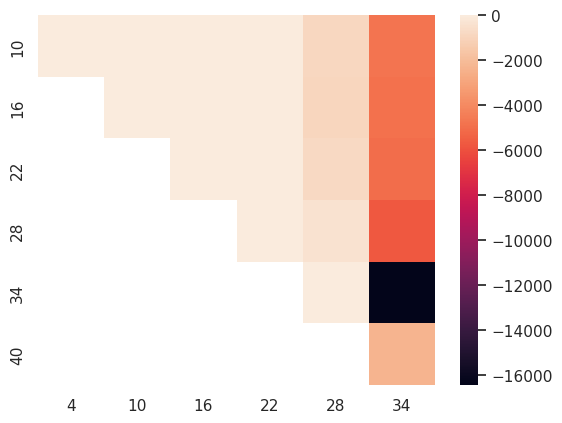

In [75]:

for ind in ["PD_0629"]:
    final_params_file_pan = f'../steps/cobraa/{ind}/aut_final_parameters.txt'
    pan_LL = get_LL_from_file(final_params_file_pan)
    matrix_LL_diffs = np.zeros(shape=(6,6))
    matrix_LL_diffs[:] = np.nan
    for te in range(10, 42, 6):
        for ts in range(4, te-4, 6):
            final_params_file_struct = f'../steps/cobraa/{ind}/aut_D50_ts{ts}_te{te}_final_parameters.txt'
            struct_LL = get_LL_from_file(final_params_file_struct)
            diff_LL = struct_LL - pan_LL
            matrix_LL_diffs[int(ts/6),int((te-6)/6)] = diff_LL
    matrix_LL_diffs = matrix_LL_diffs**3 
    g = sns.heatmap(matrix_LL_diffs)
    g.set(xticklabels=list(range(4, te-4, 6)), yticklabels=list(range(10, 42, 6)))

In [73]:
matrix_LL_diffs

array([[ 1.44966993e-05,  8.38876794e-04, -8.66093892e-01,
        -9.05169708e+00, -8.59711555e+02, -4.80794714e+03],
       [            nan,  4.60958370e-05, -6.55501064e-01,
        -4.08301397e+00, -9.55046701e+02, -4.87945268e+03],
       [            nan,             nan, -4.26081285e-01,
        -3.64161832e+00, -7.88352932e+02, -5.03146206e+03],
       [            nan,             nan,             nan,
        -5.07302704e-01, -4.05987928e+02, -5.72237682e+03],
       [            nan,             nan,             nan,
                    nan, -4.99578671e+01, -1.64292870e+04],
       [            nan,             nan,             nan,
                    nan,             nan, -2.32037938e+03]])